# **TÌM KIẾM INSIGHT CỦA DỮ LIỆU**
---

Import các thư viện cần thiết

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as gp
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

Đọc dữ liệu đã được tiền xử lý

In [46]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,age,sex,race,marital_status,education,employment_status,income_level,books_read_last_12m,read_printed_books_last_12m,read_audiobooks_last_12m,read_ebooks_last_12m,last_book_read_source,read_daily_news,read_magazines_journals
0,46,Male,Native American,Married,High school,Employed full-time,<$10k,97,Yes,Yes,Yes,Purchased,Yes,Yes
1,32,Male,Mixed race,Never been married,High school,Employed full-time,<$10k,97,No,Yes,Yes,Borrowed from others,Yes,Yes
2,27,Male,Mixed race,Married,High school,Employed full-time,$40k-50k,97,Yes,No,Yes,Borrowed from library,Yes,No
3,16,Female,Mixed race,Never been married,Some high school,Employed part-time,$10k-20k,97,Yes,Yes,No,Purchased,Yes,No
4,55,Female,Asian/Pacific Islander,Divorced,Some college,Self-employed,$40k-50k,97,Yes,Yes,Yes,Purchased,No,No


## CÂU 1: NHỮNG YẾU TỐ NÀO ẢNH HƯỞNG NHIỀU NHẤT TỚI SỐ LƯỢNG SÁCH ĐỌC TRONG 12 THÁNG VỪA QUA (**BOOKS_READ_LAST_12M**) ?

### 1. Lợi ích của việc trả lời câu hỏi

- Trả lời câu hỏi giúp dễ dàng tìm kiếm các câu hỏi liên quan tới số lượng sách đọc trong 12 tháng qua - 1 thông tin quan trọng giúp xác định thói quen đọc sách, từ đó dễ dàng tìm ra những insight của dữ liệu hơn.

### 2. Tiền xử lý

#### a) Mô tả thuật toán

- Để xác định những feature ảnh hưởng nhiều nhất tới `books_read_last_12m`, ta sẽ sử dụng thuật toán RandomForestRegression để lấy ra thông tin về những feature quan trọng nhất. 
    + Loại bỏ các giá trị ngoại lai của `books_read_last_12m` bằng IQR để mô hình chính xác hơn.

    + Tách dữ liệu ra thành target (`books_read_last_12m`) và features (các cột còn lại) rồi encode cho các cột kiểu phân loại. 

    + Chia dữ liệu thành tập train và test để tránh overfitting.

    + Áp dụng dữ liệu trên tập train và lấy ra thông tin về các features quan trọng nhất. 

#### b) Code

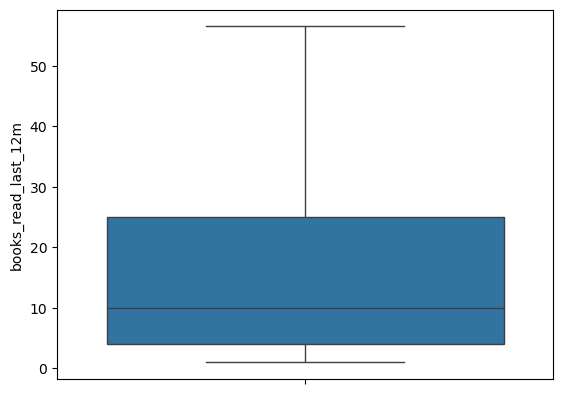

In [47]:
# Xử lý ngoại lai trong Number of books read bằng IQR
def handle_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    series_clipped = series.clip(lower=lower_bound, upper=upper_bound)
    return series_clipped

data = df.copy()
data['books_read_last_12m'] = handle_outliers(data['books_read_last_12m'])
sns.boxplot(data=data['books_read_last_12m']);

In [48]:
# Tách features và target
X = data.drop(columns=['books_read_last_12m'])
y = data['books_read_last_12m']

In [49]:
# Encode các cột object
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [50]:
# Chia dữ liệu thành 2 tập để tránh overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng Random Forest cho tập train 
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Lấy độ quan trọng của các đặc trưng
feature_importances = model.feature_importances_
feature_names = X.columns

### 3. Trực quan

In [51]:
# Tạo 1 dataframe lưu độ tương quan của từng feature với 'books_read_last_12m'
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

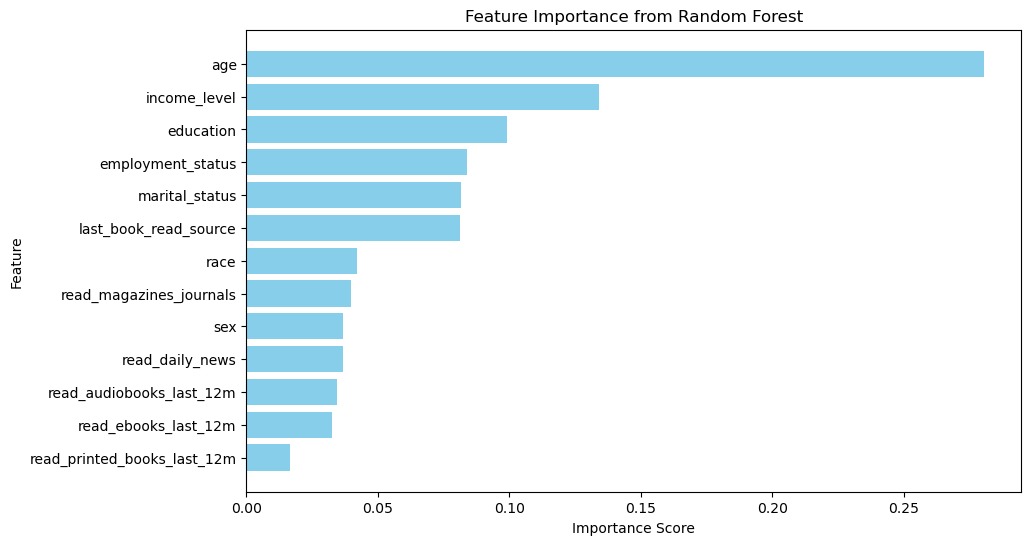

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### 4. Nhận xét và rút ra kết luận

- Nhận xét: 
    - Như vây, cột `age` ảnh hưởng nhiều nhất tới số lượng sách đọc, theo sau đó là `income_level` và `education`. Tuy nhiên mức độ quan trọng của những cột này cũng không quá cao, chỉ khoảng từ 0.1 -> 0.3 (tương quan khá yếu).

    - Các cột `read_audiobooks_last_12m`, `read_ebooks_last_12m`, `read_printed_books_last_12m`, `read_magazines_journals`, `read_daily_news` hầu như không ảnh hưởng tới số lượng sách đọc, với mức tương quan thấp ~ 0.

## CÂU 2. SỐ LƯỢNG SÁCH ĐỌC THAY ĐỔI NHƯ THẾ NÀO THEO MỨC THU NHẬP VÀ GIỚI TÍNH?

### 1. Lợi ích của việc trả lời câu hỏi


- Trả lời câu hỏi này giúp tìm hiểu xem mức thu nhập ảnh hưởng tới sự thay đổi thói quen đọc sách của nam và nữ như thế nào? Liệu nam giới hoặc nữ giới có thích đọc sách hơn giới tính còn lại hay không. Từ đó phát triển chiến lược tiếp thị phù hợp với từng cá nhân theo độ tuổi và mức thu nhập.

### 2. Tiền xử lý

#### a) Mô tả thuật toán

- Để trả lời câu hỏi này, nhóm sử dụng dữ liệu của cột **Incomes**, **Sex** và **Number of books read**.

- Thuật toán được thực hiện theo các bước sau:
    
    + Nhóm dữ liệu theo **Incomes** và **Sex** để tính tổng số sách đọc theo mức thu nhập của từng giới tính.

    + Tạo 1 dataframe mới với 3 cột là **Incomes**, **Male** và **Female** với dữ liệu của **Male** và **Female** là số sách đọc theo mức thu nhập của 3 giới tính nam và nữ. 

#### b) Code

In [53]:
# Tạo bảng thống kê số lượng sách của Nam và Nữ theo Income Range
book_counts = df.groupby(['income_level', 'sex'])['books_read_last_12m'].mean().reset_index()

income_level = ['<$10k', '$10k-20k','$20k-30k','$30k-40k', '$40k-50k', '$50k-75k', '$75k-100k', '$100k-150k']
book_counts_by_incomes = book_counts.pivot(index= 'income_level', columns = 'sex', values='books_read_last_12m')
book_counts_by_incomes.index = pd.Categorical(book_counts_by_incomes.index, categories=income_level, ordered=True)
book_counts_by_incomes.sort_index(inplace=True)
book_counts_by_incomes.reset_index(inplace=True)
book_counts_by_incomes.columns.name = None 

# Làm tròn thành số nguyên
book_counts_by_incomes[['Female', 'Male']] = book_counts_by_incomes[['Female', 'Male']].round(0).astype(int)
book_counts_by_incomes

,index,Female,Male
0,<$10k,17,25
1,$10k-20k,21,18
2,$20k-30k,22,15
3,$30k-40k,23,12
4,$40k-50k,20,17
5,$50k-75k,23,17
6,$75k-100k,22,15
7,$100k-150k,25,16


### 3. Trực quan

In [54]:
y_incomes = book_counts_by_incomes['index']
x_M = book_counts_by_incomes['Male'] * (-1)
x_F = book_counts_by_incomes['Female']

fig = gp.Figure() 
  
# Dữ liệu của nam giới
fig.add_trace(gp.Bar(y= y_incomes, x = x_M,  
                     name = 'Male',  
                     orientation = 'h')) 

# Dữ liệu của nữ giới
fig.add_trace(gp.Bar(y = y_incomes, x = x_F, 
                     name = 'Female', orientation = 'h'))
 
fig.update_layout(title = 'Population Pyramid', 
                 title_font_size = 22, barmode = 'relative', 
                 bargap = 0.0, bargroupgap = 0, 
                 xaxis = dict(tickvals = [-30, -25, -20, -15, -10, -5, 
                                          0, 5, 10, 15, 20, 25, 30], 
                                
                              ticktext = ['30', '25', '20', '15', '10', '5', 
                                          '0', '5', '10', '15', '20', '25', '30'], 
                                
                              title = 'Average Number of books read', 
                              title_font_size = 14) 
                 ) 
  
fig.show()

### 4. Nhận xét và rút ra kết luận.

Nhận xét:

- Với mức thu nhập thấp nhất tương ứng thu nhập nằm trong khoảng dưới $10000, nam giới đọc nhiều sách hơn nữ giới với trung bình số cuốn sách đọc trong 1 năm là  24 cuốn, gấp 1.6 lần nữ giới với số cuốn sách đọc trung bình là 15 cuốn. 

- Với mức thu nhập cao hơn, nữ giới đọc nhiều sách hơn nam giới. Sự chệnh lệch này giao động từ gấp 1.17 lần tới 1.91 lần. 

Kết luận: Nhìn chung, nữ giới có xu hướng đọc nhiều sách hơn nam giới. Khi thu nhập càng cao, sự khác biệt đó càng tăng. Điều này cho thấy nữ giới có xu hướng đọc sách để nâng cấp bản thân khi ở mức thu nhập cao hơn nam giới.

## CÂU 3: MỨC ĐỘ QUAN TÂM TỚI CÁC ẤN PHẨM ĐỊNH KỲ CÓ SỰ KHÁC BIỆT THEO ĐỘ TUỔI VÀ TRÌNH ĐỘ HỌC VẤN NHƯ THẾ NÀO?

### 1. Lợi ích của việc trả lời câu hỏi

- Tìm hiểu về mức độ quan tâm tới các ấn phẩm định kỳ giúp hiểu được thói quen đọc các thể loại sách báo, tạp chí của từng lứa tuổi và trình độ học vấn, từ đó xác định xem độ tuổi và trình độ học vấn nào ưa thích các loại ấn phẩm này.

- Việc khám phá sở thích đọc sách báo của mỗi người giúp cho các nhà phát hành sách và bản tin có chiến lược phù hợp để đưa nguồn sách này tiếp cận tới đúng đối tượng quan tâm nó.

### 2. Tiền xử lý

#### a) Mô tả thuật toán

- Để trả lời câu hỏi này, nhóm sử dụng thông tin của các cột **Daily news/newspapers reader?**, **Magazines/Journals Reader?**, ***Age** và **Education**.

- Thuật toán sẽ theo các bước sau:

    + Nhóm độ tuổi theo các nhóm tuổi [(15-25), (25-35), (35-45), (45-55), (55-65), (65-75), (75-85), (85-95)].

    + Tạo dataframe chứa thông tin về hành vi đọc các ấn phẩm theo kỳ theo độ tuổi và trình độ học vấn.

    + Nhóm số người đọc các ấn phẩm in theo nhóm tuổi và trình độ học vấn. 

    + Đặt trình độ học vấn làm index theo thứ tự tự định nghĩa cho 2 nhóm người đọc sách báo và người đọc tạp chí.

#### b) Code

In [55]:
# Xác định khoảng giá trị (bins) và nhãn (labels)
age_bins = [15, 25, 35, 45, 55, 65, 75, 85, 95]
age_labels = ['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85-95']

In [56]:
# Tạo dataframe chứa thông tin về hành vi đọc các ấn phẩm theo kỳ theo độ tuổi và trình độ học vấn
printed_media_df = pd.DataFrame()
printed_media_df['age'] = df['age']
printed_media_df['read_daily_news'] = df['read_daily_news']
printed_media_df['read_magazines_journals'] = df['read_magazines_journals']
printed_media_df['education'] = df['education']
printed_media_df['age_group'] = pd.cut(printed_media_df['age'], bins=age_bins, labels=age_labels, right=False)
printed_media_df.head(10)

,age,read_daily_news,read_magazines_journals,education,age_group
0,46,Yes,Yes,High school,45-55
1,32,Yes,Yes,High school,25-35
2,27,Yes,No,High school,25-35
3,16,Yes,No,Some high school,15-25
4,55,No,No,Some college,55-65
5,63,Yes,No,Some college,55-65
6,60,Yes,Yes,College,55-65
7,50,Yes,No,Post-graduate,45-55
8,29,No,No,High school,25-35
9,23,Yes,Yes,High school,15-25


Index(['age', 'sex', 'race', 'marital_status', 'education',
       'employment_status', 'income_level', 'books_read_last_12m',
       'read_printed_books_last_12m', 'read_audiobooks_last_12m',
       'read_ebooks_last_12m', 'last_book_read_source', 'read_daily_news',
       'read_magazines_journals'],
      dtype='object')

In [57]:
# Tạo dataframe để vẽ biểu đồ nhiêt
# 1. Lọc các giá trị Daily news/newspapers reader? = 1
newspaper_count_df = printed_media_df[printed_media_df['read_daily_news'] == 'Yes']

# 2. Đếm số người đọc sách in theo Education và Age
grouped_newspaper_df = newspaper_count_df.groupby(['education', 'age_group']).size().reset_index(name='Count')

# 3. Tạo bảng pivot để sử dụng trong biểu đồ nhiệt
pivot_table_newspaper = grouped_newspaper_df.pivot(index='education', columns='age_group', values='Count').fillna(0)

# 4. Sắp xếp theo trình độ học vấn tự định nghĩa
education_order = ['Some high school', 'High school', 'Trade school', 'Some college', 'College', 'Post-graduate']
pivot_table_newspaper.index = pd.Categorical(pivot_table_newspaper.index, categories=education_order, ordered=True)
pivot_table_newspaper.sort_index(inplace=True)
pivot_table_newspaper

age_group,15-25,25-35,35-45,45-55,55-65,65-75,75-85,85-95
Some high school,45,3,6,6,8,8,4,0
High school,39,41,30,47,53,37,17,8
Trade school,2,4,6,4,6,3,3,0
Some college,46,38,34,75,54,43,15,5
College,16,48,58,68,65,47,16,3
Post-graduate,5,43,56,48,71,46,24,2


In [58]:
# Tương tự cho magazine
magazine_count_df = printed_media_df[printed_media_df['read_magazines_journals'] == 'Yes']

grouped_nagazine_df = magazine_count_df.groupby(['education', 'age_group']).size().reset_index(name='Count')

pivot_table_magazine = grouped_nagazine_df.pivot(index='education', columns='age_group', values='Count').fillna(0)

pivot_table_magazine.index = pd.Categorical(pivot_table_magazine.index, categories=education_order, ordered=True)
pivot_table_magazine.sort_index(inplace=True)
pivot_table_magazine

age_group,15-25,25-35,35-45,45-55,55-65,65-75,75-85,85-95
Some high school,57,2,6,6,5,8,2,0
High school,41,34,19,36,41,29,17,6
Trade school,3,4,4,6,5,2,2,0
Some college,43,34,39,64,38,32,11,4
College,14,39,68,73,58,41,13,3
Post-graduate,4,32,50,52,69,47,21,3


### 3. Trực quan

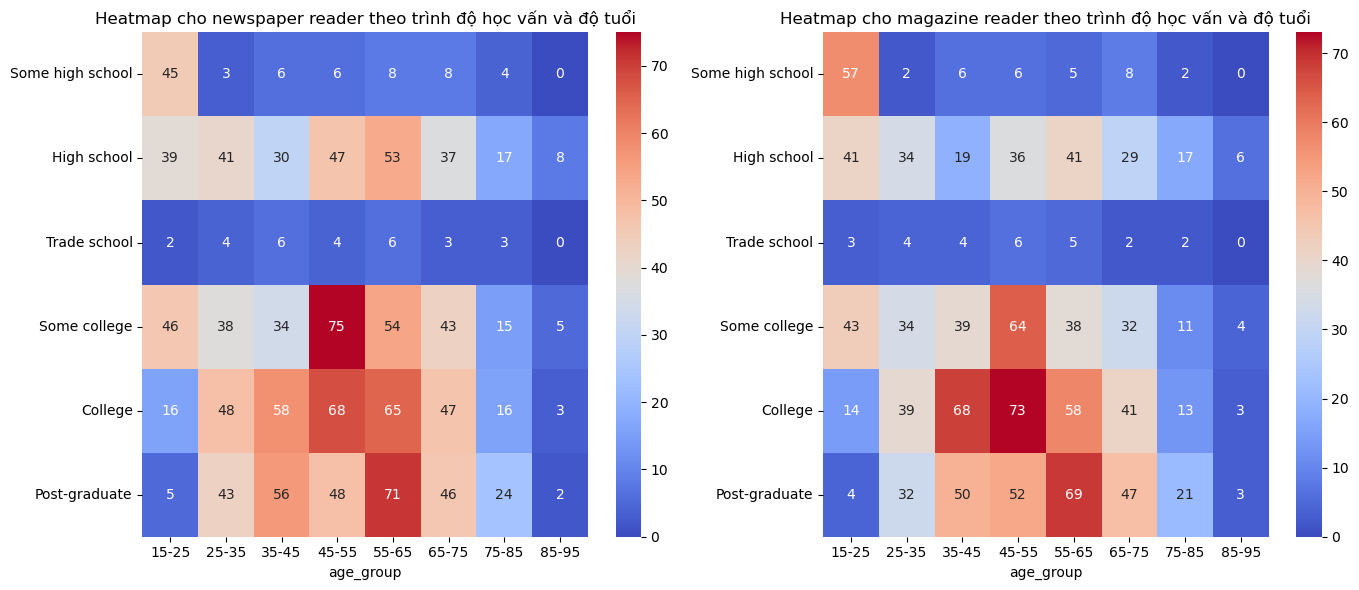

In [59]:
# plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột

# Heatmap cho newspaper reader
sns.heatmap(
    pivot_table_newspaper, 
    ax=axes[0],
    cmap="coolwarm",  
    annot=True,
    fmt=".0f",
    cbar=True
)
axes[0].set_title("Heatmap cho newspaper reader theo trình độ học vấn và độ tuổi")

# Heatmap cho magazine reader
sns.heatmap(
    pivot_table_magazine, 
    ax=axes[1],
    cmap="coolwarm",  
    annot=True,
    fmt=".0f",
    cbar=True
)
axes[1].set_title("Heatmap cho magazine reader theo trình độ học vấn và độ tuổi")

plt.tight_layout()
plt.show()

### 4. Nhận xét và rút ra kết luận.

- Nhận xét:
    + Nhìn chung, số lượng người đọc giảm dần ở các độ tuổi lớn hơn, đặc biệt là ở độ tuổi từ 65 trở đi.

    + 2 nhóm người: người đã hoàn thành bậc đại học (college) và chưa hoàn thành bậc đại học (some college) ở độ tuổi từ 45-55 và 55-65 có đọc các ấn phẩm in ấn định kỳ nhiều nhất.

    + Nhóm đang chưa hoàn thành bậc trung học phổ thông (Some high school) và nhóm người đang học các trường cao đẳng nghề(Trade school) có số lượng đọc thấp hơn đáng kể so với các nhóm có trình độ học vấn khác.

- Kết luận:
    + Độ tuổi từ 45-65 là nhóm tiêu thụ chính cả newspaper và magazine. Điều này cho thấy nhóm trung niên và lớn tuổi có thói quen đọc mạnh mẽ hơn, đặc biệt là với các nội dung phù hợp cho tuổi này.

    + Nhóm có trình độ học vấn cao từ bậc đại học trở lên có xu hướng đọc nhiều hơn cả newspaper và magazine. Đây là nhóm có thể quan tâm đến các nội dung chuyên sâu hoặc phù hợp với nghề nghiệp và sở thích của họ. 

    + Magazine có xu hướng phổ biến hơn newspaper trong mọi nhóm độ tuổi và trình độ học vấn. Điều này có thể do magazine thường có nội dung đa dạng, phong phú và cách trình bày hấp dẫn hơn.

## CÂU 4: TÌNH TRẠNG HÔN NHÂN VÀ VIỆC ĐỌC SÁCH ĐIỆN TỬ/SÁCH IN/SÁCH NÓI TRONG MỘT NĂM CÓ MỐI QUAN HỆ NHƯ THẾ NÀO?

### 1. Lợi ích của việc trả lời câu hỏi
Hiểu rõ hơn về các nhóm độc giả, mà còn tạo ra những cơ hội mới để phát triển sản phẩm, chiến lược tiếp thị và nội dung phù hợp, đồng thời mang lại giá trị lớn cho các tổ chức trong ngành xuất bản, công nghệ và nghiên cứu hành vi tiêu dùng.

### 2. Tiền xử lý

#### a. Các thuộc tính liên quan:
- 'marital_status'
- 'read_printed_books_last_12m'
- 'read_audiobooks_last_12m'
- 'read_ebooks_last_12m'

#### b. Các bước xử lí: 
- Chuyển đổi dữ liệu: Các cột liên quan đến việc đọc sách (sách in, sách điện tử, sách nói) được chuyển đổi thành giá trị có thể phân tích (Yes/No thành 1/0).
- Tạo các nhóm theo tình trạng hôn nhân
- Kiểm tra sự phân phối: Dùng các biểu đồ tròn để xem tỷ lệ người đọc sách điện tử, sách in, sách nói theo tình trạng hôn nhân.
- Phân tích kết quả: Xem liệu có sự khác biệt rõ rệt giữa các nhóm tình trạng hôn nhân đối với việc đọc các loại sách hay không.

In [60]:
# Chuẩn hóa cột 'marital_status' thành các nhóm
def map_marital_status(status):
    if status in ['Married', 'Living with a partner']:
        return 'Married or Living with a partner'
    elif status in ['Single', 'Never been married']:
        return 'Single'
    elif status == 'Divorced':
        return 'Divorced'
    elif status == 'Widowed':
        return 'Widowed'
    elif status == 'Separated':
        return 'Separated'
    else:
        return 'Unknown'
    
df4 = df.copy()

df4['Marital Status Grouped'] = df4['marital_status'].apply(map_marital_status)
print(df4[['marital_status', 'Marital Status Grouped']].head())

       marital_status            Marital Status Grouped
0             Married  Married or Living with a partner
1  Never been married                            Single
2             Married  Married or Living with a partner
3  Never been married                            Single
4            Divorced                          Divorced


### 3. Trực quan 

#### a. Mối quan hệ giữa tình trạng hôn nhân với việc đọc sách điện tử:

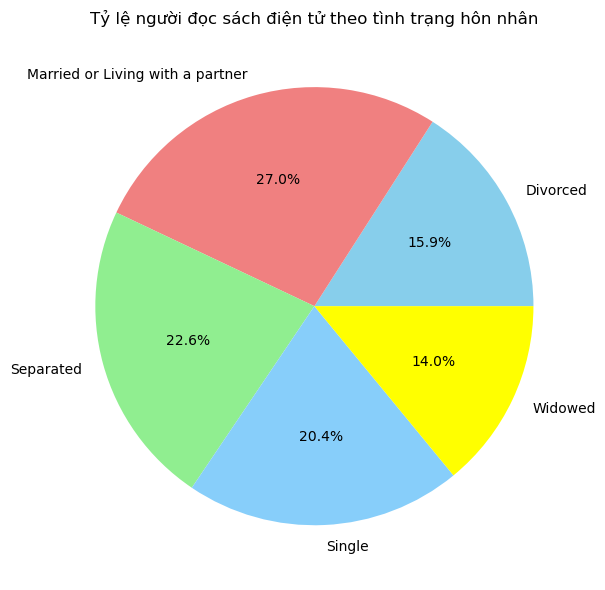

In [61]:
# Tiền xử lí: Chuyển đổi cột 'read_ebooks_last_12m' từ Yes/No thành 1/0
df4['read_ebooks_last_12m'] = df4['read_ebooks_last_12m'].map({'Yes': 1, 'No': 0})
marital_e_books = df4.groupby('Marital Status Grouped')['read_ebooks_last_12m'].mean() 

plt.figure(figsize=(8,6))
marital_e_books.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'yellow', 'pink'])
plt.title('Tỷ lệ người đọc sách điện tử theo tình trạng hôn nhân')
plt.ylabel('')  
plt.tight_layout()
plt.show()

##### Nhận xét:
- Nhóm "Married or Living with a partner" dẫn đầu trong việc đọc sách điện tử, có thể do họ tìm kiếm sự tiện lợi trong việc truy cập tài liệu.
- Các nhóm độc thân, ly thân, hoặc ly hôn cũng có tỷ lệ tương đối.
- Tỷ lệ thấp ở nhóm "Widowed" có thể gợi ý nhu cầu cung cấp các chương trình hoặc nền tảng hỗ trợ nhóm này tiếp cận công nghệ đọc sách điện tử.
- Chênh lệch giữa nhóm cao nhất "Married or Living with a partner" và nhóm thấp nhất "Widowed" khá đáng kể, cho thấy tình trạng hôn nhân có ảnh hưởng đến thói quen đọc sách điện tử.

#### b. Mối quan hệ giữa tình trạng hôn nhân với việc đọc sách in:

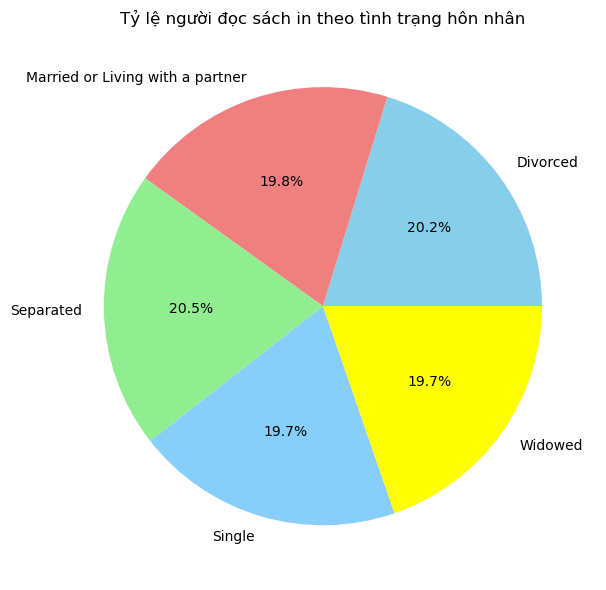

In [62]:
# Tiền xử lí: Chuyển đổi cột 'read_printed_books_last_12m' từ Yes/No thành 1/0
df4['read_printed_books_last_12m'] = df4['read_printed_books_last_12m'].map({'Yes': 1, 'No': 0})
marital_e_books = df4.groupby('Marital Status Grouped')['read_printed_books_last_12m'].mean() 

plt.figure(figsize=(8,6))
marital_e_books.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'yellow', 'pink'])
plt.title('Tỷ lệ người đọc sách in theo tình trạng hôn nhân')
plt.ylabel('')  
plt.tight_layout()
plt.show()

##### Nhận xét: 
- Sách in vẫn giữ được sức hút đồng đều giữa các nhóm tình trạng hôn nhân, không có sự chênh lệch rõ rệt nào về tỷ lệ sử dụng.
- Tỷ lệ cao nhất thuộc về nhóm "Separated" (20.5%), có thể do nhu cầu thư giãn hoặc học hỏi.
- Nhóm "Widowed" và "Single" có xu hướng thấp hơn đôi chút, có thể họ ưu tiên các phương tiện khác.

#### c. Mối quan hệ giữa tình trạng hôn nhân với việc đọc sách nói:

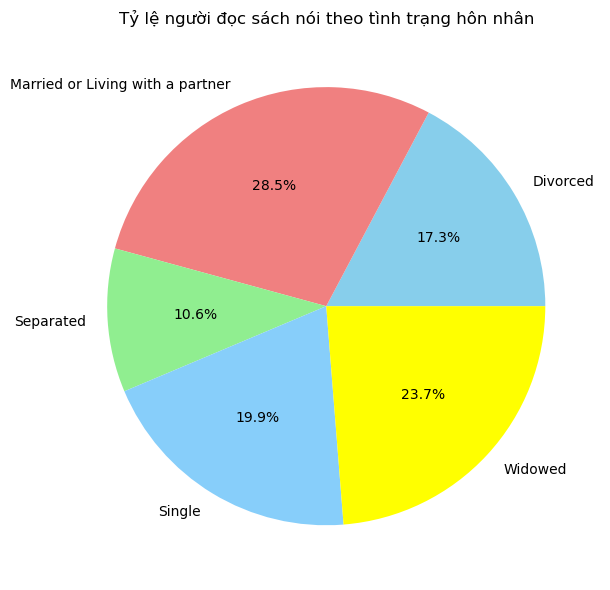

In [63]:
# Chuyển đổi cột 'read_audiobooks_last_12m' từ Yes/No thành 1/0
df4['read_audiobooks_last_12m'] = df4['read_audiobooks_last_12m'].map({'Yes': 1, 'No': 0})
marital_e_books = df4.groupby('Marital Status Grouped')['read_audiobooks_last_12m'].mean() 

plt.figure(figsize=(8,6))
marital_e_books.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'yellow', 'pink'])
plt.title('Tỷ lệ người đọc sách nói theo tình trạng hôn nhân')
plt.ylabel('')  
plt.tight_layout()
plt.show()

##### Nhận xét: 
- Sách nói phổ biến nhất ở nhóm "Married or Living with a partner", có thể họ tận dụng lợi ích tiện lợi của sách nói trong cuộc sống hàng ngày.
- Nhóm "Widowed" cũng có tỷ lệ sử dụng cao, sách nói có thể là hình thức giải trí phù hợp với nhóm đối tượng này.
- Tỷ lệ thấp ở nhóm "Separated", có thể do họ ít tiếp cận với phương tiện này hoặc có ít thời gian hơn để sử dụng sách nói.

### 4. Kết luận chung: 
- Nhóm "Married or Living with a partner" sử dụng sách điện tử và sách nói nhiều nhất.
- Sách in phổ biến và ổn định trong mọi nhóm.
- Nhóm "Widowed" ưa chuộng sách nói, trong khi nhóm "Separated" có xu hướng ít sử dụng cả ba loại sách.
- Như vậy, nhu cầu đọc sách thay đổi dựa trên tình trạng hôn nhân và cách mỗi nhóm sử dụng các hình thức đọc để phù hợp với lối sống của họ. Điều này cung cấp thông tin hữu ích cho các chiến lược tiếp thị và phát triển sản phẩm trong ngành xuất bản.

## Câu 5. Mức độ học vấn cao hơn có thực sự dẫn đến thói quen đọc đa dạng hơn không?

### 1. Lợi ích của việc trả lời câu hỏi

Việc nghiên cứu mối quan hệ giữa học vấn và đa dạng thói quen đọc mang lại lợi ích cho nhiều bên: giúp ngành giáo dục cải thiện phương pháp đào tạo, hỗ trợ nhà xuất bản tối ưu sản phẩm theo phân khúc, đồng thời cung cấp dữ liệu để phát triển chính sách văn hóa đọc hiệu quả và phục vụ nghiên cứu khoa học.

### 2. Tiền xử lý

**a. Mô tả thuật toán**

Thuật toán gồm 2 phần chính:

Tạo chỉ số đa dạng đọc (reading_diversity_score):
* Tính tổng số loại format đọc mà mỗi người sử dụng
* Chuyển đổi các câu trả lời 'Yes' thành 1, 'No' thành 0
* Cộng điểm cho mỗi format: sách in, sách nói, ebook, tin tức, tạp chí
* Điểm càng cao thể hiện người đó càng đọc đa dạng format


Tạo biểu đồ radar so sánh thói quen đọc theo học vấn:
* Tính tỷ lệ người đọc từng format trong mỗi nhóm học vấn
* Vẽ biểu đồ radar với 5 trục tương ứng 5 format đọc
* Mỗi đường trong biểu đồ thể hiện một nhóm học vấn
* Càng xa tâm thể hiện tỷ lệ đọc format đó càng cao

Biểu đồ này giúp trực quan hóa sự khác biệt về thói quen đọc giữa các nhóm trình độ học vấn khác nhau.

**b. Code**

In [35]:
df5 = df.copy()

In [64]:
# 1. Tạo chỉ số tổng hợp về khẩu vị đọc
df5['reading_diversity_score'] = (
        (df5['read_printed_books_last_12m'] == 'Yes').astype(int) +
        (df5['read_audiobooks_last_12m'] == 'Yes').astype(int) +
        (df5['read_ebooks_last_12m'] == 'Yes').astype(int) +
        (df5['read_daily_news'] == 'Yes').astype(int) +
        (df5['read_magazines_journals'] == 'Yes').astype(int)
    )

    # 2. Phân tích đa chiều với biểu đồ radar
plt.figure(figsize=(15, 10))
    
    # Chuẩn hóa dữ liệu để vẽ biểu đồ radar
categories = ['Printed Books', 'Audiobooks', 'Ebooks', 'Daily News', 'Magazines']
    
def normalize_reading(series):
    return (series == 'Yes').astype(float).mean()
    
    # Tạo dữ liệu cho từng nhóm
reading_by_education = df5.groupby('education').agg({
        'read_printed_books_last_12m': normalize_reading,
        'read_audiobooks_last_12m': normalize_reading,
        'read_ebooks_last_12m': normalize_reading,
        'read_daily_news': normalize_reading,
        'read_magazines_journals': normalize_reading
    })
    

<Figure size 1500x1000 with 0 Axes>

### 3. Trực quan

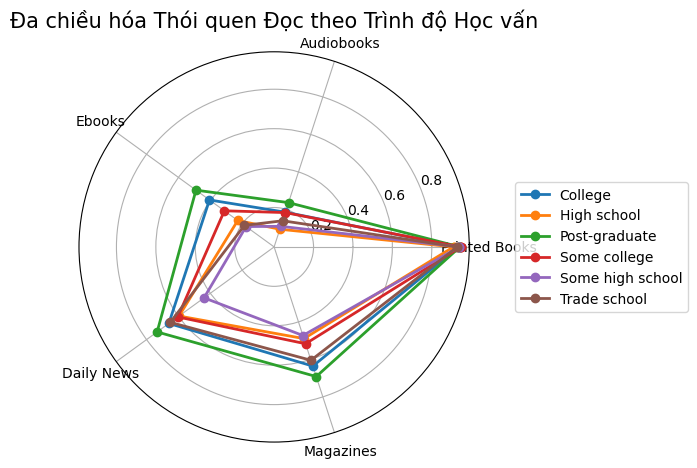

In [65]:
    # Vẽ biểu đồ radar
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
    
plt.subplot(polar=True)
for idx, education in enumerate(reading_by_education.index):
        values = reading_by_education.loc[education].values
        values = np.concatenate((values, [values[0]]))
        
        plt.polar(angles, values, 'o-', linewidth=2, 
                  label=f'{education}')
    
plt.thetagrids(angles[:-1] * 180/np.pi, categories)
plt.title('Đa chiều hóa Thói quen Đọc theo Trình độ Học vấn', size=15)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.show()


### 4. Nhận xét chung

Từ biểu đồ radar về thói quen đọc theo trình độ học vấn, rút ra nhận xét như sau:

- Xu hướng đọc theo trình độ học vấn:
    - Nhóm có học vấn cao (Post-graduate và College graduate) thể hiện mức độ đọc đa dạng vượt trội
    - Diện tích đường radar của họ lớn nhất, cho thấy sự tích cực trong việc sử dụng nhiều format đọc
    - Nhóm có học vấn thấp hơn (High school incomplete) có xu hướng đọc ít đa dạng hơn, tập trung chủ yếu vào một số format truyền thống

- So sánh giữa các format đọc:
    - Sách in (Printed Books) là format phổ biến và được sử dụng đều đặn ở mọi nhóm học vấn
    - Audiobooks và Ebooks cho thấy sự phân hóa rõ rệt, được ưa chuộng hơn ở nhóm có học vấn cao
    - Tin tức hàng ngày (Daily News) và tạp chí (Magazines) cũng được nhóm học vấn cao tiêu thụ nhiều hơn

- Xu hướng công nghệ và học vấn:
    - Nhóm có học vấn cao thích nghi tốt với các format đọc hiện đại
    - Họ có xu hướng kết hợp nhiều format đọc khác nhau
    - Nhóm học vấn thấp hơn có vẻ chậm trong việc áp dụng các công nghệ đọc mới


**Kết luận** Mức độ học vấn cao hơn không chỉ dẫn đến thói quen đọc đa dạng hơn mà còn thể hiện sự thích nghi tốt với các format đọc hiện đại. Điều này có thể là do họ có khả năng tiếp cận công nghệ tốt hơn, nhu cầu thông tin đa dạng hơn, và có thể là điều kiện kinh tế thuận lợi hơn để tiếp cận nhiều format đọc khác nhau. Phát hiện này có ý nghĩa quan trọng trong việc phát triển chính sách giáo dục, chiến lược xuất bản và các chương trình khuyến đọc phù hợp với từng nhóm đối tượng.

## Câu 6. Liệu chúng ta có thể dự đoán xem một người có thói quen đọc tạp chí không dựa trên một số đặc điểm nhất định? Những đặc điểm nào có thể dùng dự đoán thói quen đọc tạp chí của một người?

Lý do tại sao chọn biến mục tiêu là **read_magazine_journals** là vì phân phối của biến này không bị lệch quá nhiều giữa hai kiểu giá trị (yes, no)

In [67]:
df6 = df.copy()

In [68]:
# Chọn features phù hợp sẽ được chọn để dự đoán
features = [
    'age', 
    'sex',
    'race',
    'marital_status',
    'education',
    'employment_status',
    'income_level',
    'books_read_last_12m',
    'read_printed_books_last_12m',
    'read_audiobooks_last_12m',
    'read_ebooks_last_12m',
    'last_book_read_source',
    'read_daily_news'
]

# Phân loại features
yes_no_features = [
    'read_printed_books_last_12m',
    'read_audiobooks_last_12m',
    'read_ebooks_last_12m',
    'read_daily_news'
]

categorical_features = [
    'sex',
    'race',
    'marital_status',
    'education',
    'employment_status',
    'income_level',
    'last_book_read_source'
]

numerical_features = [
    'age',
    'books_read_last_12m',
]

In [69]:
# Chuẩn bị dữ liệu
def prepare_data(df):
    X = df[features].copy()
    y = (df['read_magazines_journals'] == 'Yes').astype(int)
    
    # Chuyển đổi Yes/No thành 1/0
    for col in yes_no_features:
        X[col] = (X[col] == 'Yes').astype(int)
    
    # Mã hóa categorical features
    encoders = {}
    for col in categorical_features:
        encoders[col] = LabelEncoder()
        X[col] = encoders[col].fit_transform(X[col])
    
    # Chuẩn hóa numerical features
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    return X, y, encoders, scaler

In [70]:
# Huấn luyện mô hình
def train_model(X, y, random_state=42):
    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Khởi tạo và huấn luyện mô hình
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=random_state
    )
    rf_model.fit(X_train, y_train)
    
    return rf_model, X_train, X_test, y_train, y_test

In [71]:
# Đánh giá mô hình
def evaluate_model(model, X_test, y_test, X_train, y_train):
    # Dự đoán và tính độ chính xác
    y_pred = model.predict(X_test)
    
    # In báo cáo phân loại
    print("\nBáo cáo phân loại:")
    print(classification_report(y_test, y_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\nĐộ chính xác cross-validation: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    
    # Vẽ confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Ma trận nhầm lẫn')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()
    
    # Vẽ feature importance
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Tầm quan trọng của các đặc điểm')
    plt.tight_layout()
    plt.show()

In [72]:
# Hàm dự đoán
def predict_magazine_reading(person_info, model, encoders, scaler):
    person_df = pd.DataFrame([person_info])
    
    # Chuyển đổi Yes/No
    for col in yes_no_features:
        if col in person_df.columns:
            person_df[col] = (person_df[col] == 'Yes').astype(int)
    
    # Mã hóa categorical
    for col in categorical_features:
        if col in person_df.columns:
            person_df[col] = encoders[col].transform(person_df[col])
    
    # Chuẩn hóa numerical
    person_df[numerical_features] = scaler.transform(person_df[numerical_features])
    
    # Dự đoán
    prediction = model.predict(person_df)[0]
    probability = model.predict_proba(person_df)[0][1]
    
    return prediction, probability


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.56      0.37      0.45       192
           1       0.58      0.76      0.66       225

    accuracy                           0.58       417
   macro avg       0.57      0.56      0.55       417
weighted avg       0.57      0.58      0.56       417


Độ chính xác cross-validation: 0.626 (±0.020)


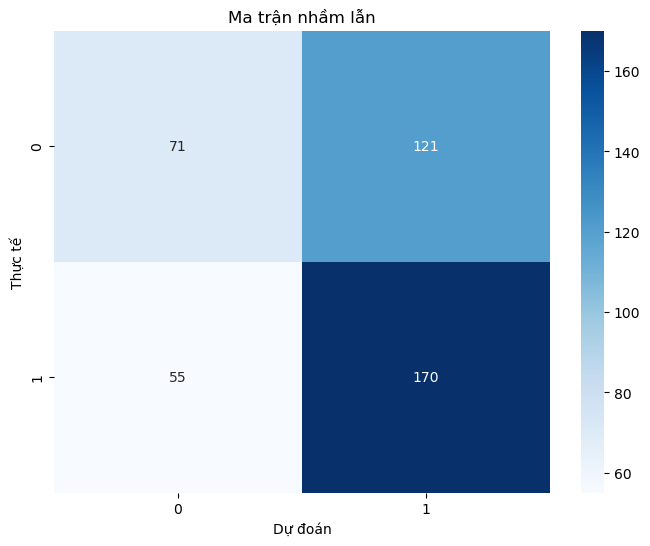

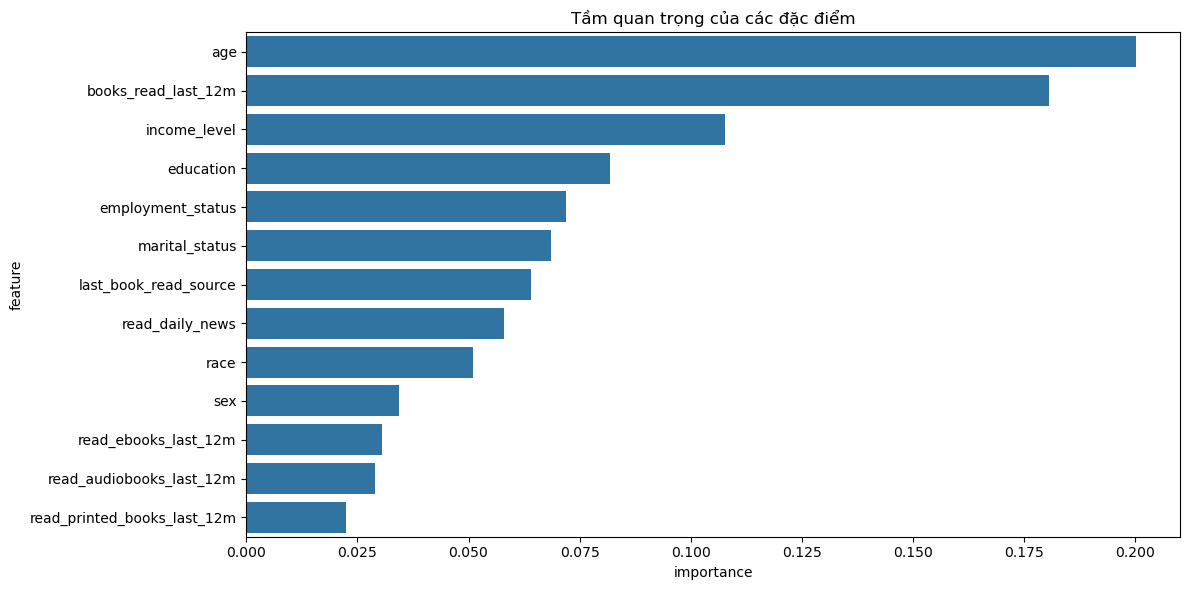


Dự đoán cho người mới:
Có đọc tạp chí: Có
Xác suất đọc tạp chí: 84.38%


In [73]:
if __name__ == "__main__":
    # Chuẩn bị dữ liệu
    X, y, encoders, scaler = prepare_data(df6)
    
    # Huấn luyện mô hình
    model, X_train, X_test, y_train, y_test = train_model(X, y)
    
    # Đánh giá mô hình
    evaluate_model(model, X_test, y_test, X_train, y_train)
    
    # Ví dụ dự đoán
    new_person = {
        'age': 46,
        'sex': 'Male',
        'race': 'Native American',
        'marital_status': 'Married',
        'education': 'High school',
        'employment_status': 'Employed full-time',
        'income_level': '<$10k',
        'books_read_last_12m': 97,
        'read_printed_books_last_12m': 'Yes',
        'read_audiobooks_last_12m': 'Yes',
        'read_ebooks_last_12m': 'Yes',
        'last_book_read_source': 'Purchased',
        'read_daily_news': 'Yes'
    }
    
    prediction, probability = predict_magazine_reading(new_person, model, encoders, scaler)
    print(f"\nDự đoán cho người mới:")
    print(f"Có đọc tạp chí: {'Có' if prediction == 1 else 'Không'}")
    print(f"Xác suất đọc tạp chí: {probability:.2%}")